# Deep Calibration: Machine Learning in Financial Modeling

In [1]:
#importing important libraries to faciliate the machine learning
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt

#### 0. Initializing Values

In [2]:
## Financial Model Parameters
N = 20 # time disrectization
S0 = np.exp(5) # initial value of the asset in multiples of np.exp(5)
strike_prices = [0,120,150,180] # strike for the call option
T = 2.0 # maturity
activator = "tanh" #Non-linear function for the machine learning layers
R = 1000 # Number of path used in the MC simulation
Ktrain = 20000 # Size of training data
Ktest = 5000 # Size of test data
epochs = 5 #Number of Iterations
r_free = 0 #Risk free rate
assumption = "Heston" # Either "Heston" or "Black-S"

#### 1. Payoff and Path Generation Functions

In [3]:
# payoff function to to calculate payoffs for asset prices
Nopt = 4  ## three options
def f(S):
     y = []
     for K in strike_prices:
         payoff = np.maximum(S-K,0) #payoff calculation for european call options
         #payoff = np.maximum(K-S,0) #payoff calculations for european put options
         y = y + [payoff]
     return(y)

In [4]:
# Path generation function, using the approximated SDE of Black Scholes to simulate asset paths
def path(S0,sigma,N,T,R=1):
     dt = T / N
     X = np.zeros((N+1,R)) + np.log(S0) #Log transformation to save space
     for j in range(N):
         dZ = np.random.normal(0,1,R)
         s = sigma
         increment = s * dZ*np.sqrt(dt)
         X[j+1,:] = X[j,:] + increment
     return np.exp(X) #Reversion of log transformation, helps keeping positive values only

In [5]:
# Path generation function, using the approximated SDE of Heston Model to simulate asset paths
def path2(S0, v0, kappa, theta, sigma, rho, N, T, R=1):
    dt = T / N
    S = np.zeros((N + 1, R))+np.log(S0) #Log transformation to save space
    v = np.zeros((N + 1, R))+v0

    for i in range(1, N + 1):
        dZ1 = np.random.normal(0, 1,R)
        dZ2 = rho * dZ1 + np.sqrt(np.maximum(0,1 - rho**2)) * np.random.normal(0, 1)

        S[i, :] = S[i - 1, :] + np.sqrt(np.maximum(0,v[i - 1, :]* dt))  * S[i - 1, :] * dZ1 
        v[i, :] = np.maximum(0, v[i - 1, :] + kappa * (theta - v[i - 1, :]) * dt + sigma * np.sqrt(np.maximum(0,v[i - 1, :] * dt)) * dZ2)

    return np.exp(S) #Reversion of log transformation, helps keeping positive values only

#### Explanation Behind Methodology
* The principle idea is that we can generate data from a model via a Euler scheme
* Simulations are used to generate some option prices
* This speaks of a function (Model) -> (prices)
* It is this function we like to invert!
* (prices) -> (Model)
* Instead of constructing the inverse we will try to find it via machine learning
* One data point consists of one sample path as input and a model parameter as output 

#### 2. Train Data Generation

In [6]:
# Creating Ktrain sample paths from the model
print("\nCreating random parameters and the corresponding option prices via Monte Carlo")
S = np.zeros( (Ktrain,R) ) #Creating Empty Containers for the generated Asset Prices
P = np.zeros( (Ktrain,) ) #Creating Empty Containers for the generated Variances
F = np.zeros( (Ktrain,Nopt) ) #Creating Empty Containers for the generated Payoffs
c = 0.1
for i in range(Ktrain):
    if (i/Ktrain >= c):
        c = c + 0.1
        print(i/Ktrain*100,'% ... ',end='\r')
    #Creating the model parameters using random functions
    sigma = np.maximum(0,np.random.normal(0.2,0.05,1))
    kappa = np.random.normal(4,0,1)
    thetha = np.random.normal(0,0,1)
    xi = np.random.normal(0.2,0,1) #Volatility of Volatility
    rho = np.random.normal(-0.5,0,1)
    if assumption == "Black-S":
        S[i,:] = path(S0,sigma,N,T,R)[N,:]  # We store only the final values
    elif assumption == "Heston":
        S[i,:] = path2(S0,sigma,kappa,thetha,xi,rho,N,T,R)[N,:]
    L = f(S[i,:])
    Lmean = np.zeros( (Nopt,) )
    for j in range(Nopt):
        Lmean[j] = np.mean(L[j]) #Monte Carlo aggregation
    F[i,:] = Lmean
    P[i] = sigma
print("Done.\n")


Creating random parameters and the corresponding option prices via Monte Carlo


C:\Users\Biju-\AppData\Local\Temp\ipykernel_20284\4070045082.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i] = sigma


Done.% ... . 



#### 3. Training Part

In [7]:
## Building architecture
depth = 5
nodes = 64

In [8]:
#Creating the inputs and output schemes for the Machine Learning part
out = Input(shape=(Nopt,))
inputs = [out]
for i in range(depth):
     out = Dense(nodes, activation=activator, trainable=True)(out)
outputs = Dense(1, activation=activator, trainable=True)(out)

In [9]:
#Implementing the defined inputs and outputs
model_par = Model(inputs=inputs, outputs=outputs)
model_par.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65    

In [10]:
#Training the model using the simulated training data
model_par.compile(optimizer='adam',loss='mean_squared_error',metrics=["R2Score"]) #adam
model_par.fit(x=F,y=P, epochs=epochs,verbose=True,batch_size=100) 
#View Outputs to see MSE and R^2


Epoch 1/5


200/200 [==============================] - 1s 1ms/step - loss: 0.0029 - r2_score: -0.1812
Epoch 2/5
200/200 [==============================] - 0s 1ms/step - loss: 0.0010 - r2_score: 0.5915
Epoch 3/5
200/200 [==============================] - 0s 1ms/step - loss: 0.0011 - r2_score: 0.5717
Epoch 4/5
200/200 [==============================] - 0s 1ms/step - loss: 0.0011 - r2_score: 0.5657
Epoch 5/5
200/200 [==============================] - 0s 1ms/step - loss: 0.0010 - r2_score: 0.5852


#### 4. Test Data Generation 

In [11]:
# Creating Ktest sample paths from the model
# Same process to before, just creating test data now.
S = np.zeros( (Ktest,R) )
P = np.zeros( (Ktest,) )
F = np.zeros( (Ktest,Nopt) )
for i in range(Ktest):
    sigma = np.maximum(0,np.random.normal(0.2,0.05,1))
    kappa = np.random.normal(4,0,1)
    thetha = np.random.normal(0,0,1)
    xi = np.random.normal(0.2,0,1) #Volatility of Volatility
    rho = np.random.normal(-0.5,0,1)
    if assumption == "Black-S":
        S[i,:] = path(S0,sigma,N,T,R)[N,:]  ## We store only the final values
    elif assumption == "Heston":
        S[i,:] = path2(S0,sigma,kappa,thetha,xi,rho,N,T,R)[N,:]
    #if i == 0:
    #    print(N)
    L = f(S[i,:])
    Lmean = np.zeros( (Nopt,) )
    for j in range(Nopt):
        Lmean[j] = np.mean(L[j])
        #if i == 0:
        #    print(L[j])
    F[i,:] = Lmean
    P[i] = sigma

C:\Users\Biju-\AppData\Local\Temp\ipykernel_20284\1875620669.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i] = sigma


#### Testing and Evaluation

In [12]:
#Predict the variances using the test data
P_predict = np.squeeze(model_par.predict(F))

157/157 [==============================] - 0s 711us/step


In [13]:
P_predict

array([0.19900334, 0.15619804, 0.22989552, ..., 0.15278815, 0.21454625,
       0.21779172], dtype=float32)

[Below] Scatter Plot of (True/Prediction) pairs
[Orange] The Diagonal


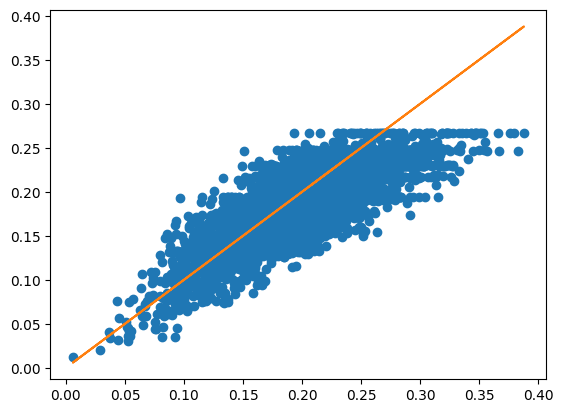

In [14]:
#Plotting the predicted data against the real data
xaxis = np.linspace(1,Ktest,Ktest)
print("[Below] Scatter Plot of (True/Prediction) pairs\n[Orange] The Diagonal")
plt.plot(P,P_predict,'o',P,P)
plt.show()

In [15]:
P_diff = P_predict - P

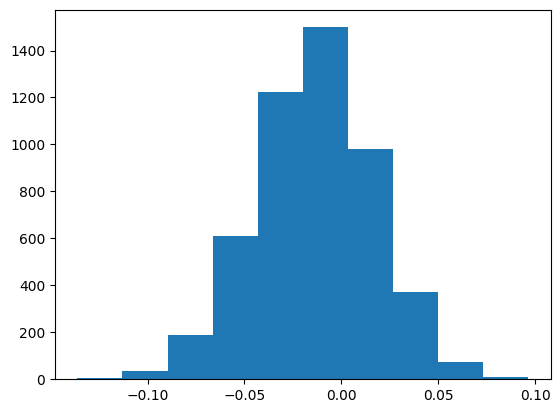

In [16]:
#Plotting the differences between real data and predicted data
plt.hist(P_diff)
plt.show()

In [17]:
#Creating metrics to judge the deviances
relmean = np.mean( P_diff/P )
relvar = np.sqrt( np.var( P_diff/P )/Ktest )
print("Error is on average",round(relmean*100,ndigits=2),"% from the truth with a standard error of:",round(relvar*100,ndigits=2),"%.")

Error is on average -5.1 % from the truth with a standard error of: 0.23 %.
